## Toxic: KMC

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [6]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
# df.head()

(159571, 24)


In [7]:
df_t = df[df['rating']>0]

In [8]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

## Dataframe A: all rating > 0 included

In [5]:
df_A = shuffle(df_t)
# df_A = df[-40000:]

In [6]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(df_A.comment_text)
X.shape

(16225, 35192)

In [7]:
SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(X, labels, metric='euclidean', sample_size=5000))
    SSEs.append(km.inertia_) 

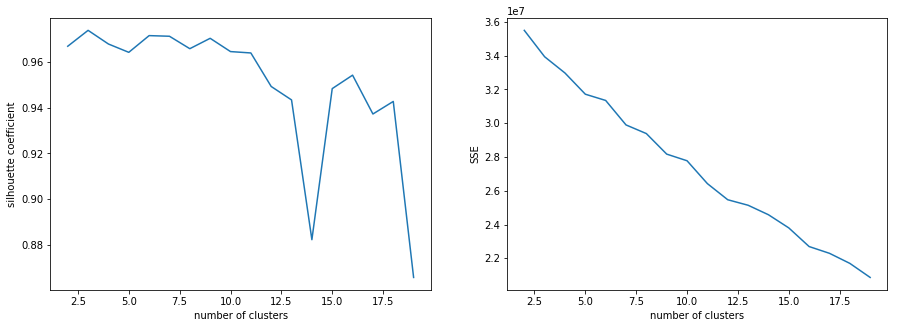

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.title('Toxic Words: Silhouette Coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE')
ax2.title('Toxic Words: Number of Clusters')

In [9]:
km = KMeans(n_clusters=10)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
mu_digits = km.cluster_centers_
mu_digits.shape

(10, 35192)

## Dataframe B: All samples downsized and randomized equally

In [9]:
df_B = shuffle(df)
# df_B = df_t[-30000:]

In [ ]:
count_vect = CountVectorizer()
X_B = count_vect.fit_transform(df_B.comment_text)
X_B.shape

(159571, 189775)

In [ ]:
SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_B)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(X_B, labels, metric='euclidean', sample_size=5000))
    SSEs.append(km.inertia_) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.title("Silhouette")

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE')
ax2.title("SSE")
plt.savefig('../charts/KMCsilhouetteSSE_3.png')

In [ ]:
km = KMeans(n_clusters=15)
km.fit(X_B)

In [ ]:
mu_digits = km.cluster_centers_
mu_digits.shape